# U-Net Model for RV Segmentation

## Training U-Net CNN

In [1]:
import sys
sys.path.append("..")
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src import data,unet

Using TensorFlow backend.


In [2]:
from keras import utils

train_dir = "/home/ubuntu/training/TrainingSet"
#train_dir = "/Users/aksharkumar/Documents/mlndCapstone/trainingdata/TrainingSet"

images=[]
inner_masks=[]
outer_masks = []

patient_directories = sorted(glob.glob(os.path.join(train_dir, "patient*")))

for patient_dir in patient_directories:
    imgdata = data.ImageData(patient_dir)
    images += imgdata.labeled_images
    inner_masks += imgdata.endo_masks.values()
    outer_masks += imgdata.epi_masks.values()

images = np.asarray(images)[:,:,:,None].astype('float64')
i_masks = np.asarray(inner_masks)
o_masks = np.asarray(outer_masks)

dims = i_masks.shape
classes = len(set(i_masks[0].flatten()))
new_shape = dims + (classes,)
i_masks = utils.to_categorical(i_masks).reshape(new_shape)
o_masks = utils.to_categorical(o_masks).reshape(new_shape)

print("There are %d total training images." % len(images))
print("There are %d total inner masks." % len(inner_masks))
print("There are %d total outer masks." % len(outer_masks))


There are 243 total training images.
There are 243 total inner masks.
There are 243 total outer masks.


In [24]:
height,width,_ = images[0].shape
dropout = 0.5

unet_conv = unet.UNet()

model = unet_conv.get_unet(height=height,width=width,channels=1,features=32,steps=3,dropout=dropout,padding='same')

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 216, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_16 (Conv2D)               (None, 216, 256, 32)  320         input_2[0][0]                    
____________________________________________________________________________________________________
activation_15 (Activation)       (None, 216, 256, 32)  0           conv2d_16[0][0]                  
____________________________________________________________________________________________________
dropout_15 (Dropout)             (None, 216, 256, 32)  0           activation_15[0][0]              
___________________________________________________________________________________________

In [25]:
from keras.optimizers import Adam
from keras import backend as K

def dice_coef(y_true, y_pred):
    #flat_y_true = K.flatten(y_true)
    #flat_y_pred = K.flatten(y_pred)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true,y_pred)

def show_plots(history):    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=[dice_coef])

In [26]:
#TODO: 1. split data into training and validation set
#      2. Augment the data
#      3. Train model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from math import ceil

seed = 0

validation_split=0.2

epochs = 200
batch_size = 20


split_index = int((1 - validation_split) * len(images))

train_steps = ceil(split_index / batch_size)
val_steps = ceil((len(images)-split_index )/batch_size)

train_images = images[:split_index]
train_inner_masks = i_masks[:split_index]

validation_images = images[split_index:]
validation_inner_masks = i_masks[split_index:]


data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.01,
                     fill_mode='nearest')

train_images_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**data_gen_args)


seed = 1
#height,width,channels = train_images[0].shape
#print(train_images[0].shape)
#print(train_inner_masks[0].shape)
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_inner_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_inner_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)


/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [29]:
checkpointer = ModelCheckpoint(filepath='saved_models/endo_models/weights50Drop.hdf5', verbose=1, save_best_only=True)

hist = model.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=2,callbacks=[checkpointer],
                   validation_data=(validation_images,validation_inner_masks),validation_steps=val_steps)
#show_plots(hist)

Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor with shape[32,216,256,32]
	 [[Node: conv2d_16/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_input_2_0_3/_193, conv2d_16/kernel/read)]]
	 [[Node: loss/mul/_215 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3838_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_16/convolution', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-bc318416ae79>", line 6, in <module>
    model = unet_conv.get_unet(height=height,width=width,channels=1,features=32,steps=3,dropout=dropout,padding='same')
  File "../src/unet.py", line 34, in get_unet
    layer = Conv2D(filters=features,kernel_size=3,padding=padding)(layer)
  File "/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/backend/tensorflow_backend.py", line 3164, in conv2d
    data_format='NHWC')
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 672, in convolution
    op=op)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 664, in op
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,216,256,32]
	 [[Node: conv2d_16/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_input_2_0_3/_193, conv2d_16/kernel/read)]]
	 [[Node: loss/mul/_215 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3838_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


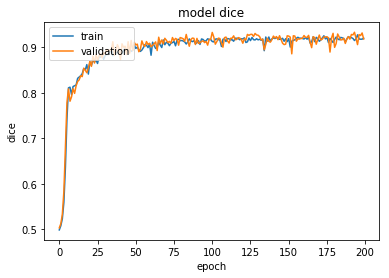

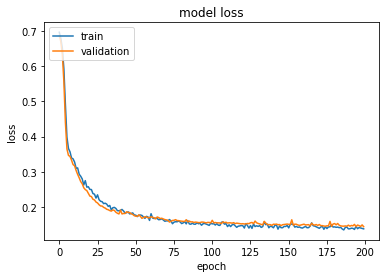

In [7]:
#print(np.max(hist.history['val_dice_coef']))
#print(np.max(hist.history['dice_coef']))

# model.load_weights('saved_models/weights.hdf5')
show_plots(hist)


In [49]:
import tensorflow as tf

model.load_weights('saved_models/endo_models/weightsNoDrop.hdf5')
def calculate_dice(images, masks_true):
    dices = []
   # image = images[0]
    #mask_pred = model.predict(image[None,:,:,:])
    #print(mask_pred.shape)
    #mask_true = masks_true[0]
    #dims = mask_true.shape
    #mask_pred_re = utils.to_categorical(mask_pred).reshape(dims)
    #print(mask_true.shape)
    #print(mask_pred_re.shape)
    #y_true = mask_true.astype('float64')
    #y_pred = mask_pred[0,:,:,:].astype('float64')
    
    #print(y_true.shape)
    #print(y_true.flatten().shape)
    #print(y_pred.shape)
    #print(y_pred.flatten().shape)
    #print(K.flatten(y_true))
    #print(K.flatten(y_pred))
    #dice = dice_coef(y_true.flatten(),y_pred.flatten())
    #for image,mask_true in zip(images,masks_true):
     #   mask_pred = model.predict(image[None,:,:,:])
      #  y_true = mask_true[:,:,1].astype('float64')
       # y_pred = mask_pred[:,:,1].astype('float64')
        #dices.append(dice_coef(y_true,y_pred))
    
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true.astype('float64')
        y_pred = mask_pred.astype('float64')
        dices.append(dice_coef(y_true.flatten(), y_pred.flatten()))
    #print(dices)
    #dice_tf = K.constant(dices,dtype='float64')
    #print(masks_pred)
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))
    #print(dice)
print("Training Statistics(No Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images,validation_inner_masks)


Training Statistics(No Dropout)...
Dice Average: 0.91 Dice Stdev: 0.03
Validation Statistics(No Dropout)...
Dice Average: 0.92 Dice Stdev: 0.02


# Results of Endocardium Model

## Training
hyperparams: {Dropout:0.5, Epochs:50, Batch Size: 20}

- train_dice = 0.62365097794
- val_dice = 0.522672422078

hyperparams: {Dropout:0.5, Epochs: 200, Batch Size: 20}

- train_dice = 0.878794970879
- val_dice = 0.841971736781

hyperparams: {Dropout:0.0, Epochs:200, Batch Size: 20}
- train_dice = 0.91 +/- 0.03
- val_dice = 0.92 +/- 0.02


In [50]:
model_epi = unet_conv.get_unet(height=height,width=width,channels=1,features=32,steps=3,dropout=dropout,padding='same')

model_epi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 216, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 216, 256, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 216, 256, 32) 0           activation_15[0][0]              
__________________________________________________________________________________________________
conv2d_17 

In [52]:
seed_epi = 10

train_outer_masks = o_masks[:split_index]

train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_outer_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_outer_masks, y=None, seed=seed)


train_outer_generator = zip(train_images_generator, train_masks_generator)

validation_outer_masks = o_masks[split_index:]
model_epi.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=[dice_coef])

/Users/aksharkumar/miniconda2/envs/rvenv/lib/python3.6/site-packages/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/Users/aksharkumar/miniconda2/envs/rvenv/lib/python3.6/site-packages/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [11]:

checkpointer = ModelCheckpoint(filepath='saved_models/epi_models/weightsNoDrop.hdf5',verbose=1,save_best_only=True)

hist_epi = model_epi.fit_generator(train_outer_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=2,callbacks=[checkpointer],
                                 validation_data=(validation_images,validation_outer_masks),validation_steps=val_steps)

Epoch 1/200
Epoch 00000: val_loss improved from inf to 0.69272, saving model to saved_models/epi_models/weightsNoDrop.hdf5
17s - loss: 0.7114 - dice_coef: 0.4918 - val_loss: 0.6927 - val_dice_coef: 0.5005
Epoch 2/200
Epoch 00001: val_loss improved from 0.69272 to 0.67302, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.6831 - dice_coef: 0.5055 - val_loss: 0.6730 - val_dice_coef: 0.5106
Epoch 3/200
Epoch 00002: val_loss improved from 0.67302 to 0.63828, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.6564 - dice_coef: 0.5199 - val_loss: 0.6383 - val_dice_coef: 0.5298
Epoch 4/200
Epoch 00003: val_loss improved from 0.63828 to 0.56203, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.6017 - dice_coef: 0.5529 - val_loss: 0.5620 - val_dice_coef: 0.5782
Epoch 5/200
Epoch 00004: val_loss improved from 0.56203 to 0.44360, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.4909 - dice_coef: 0.6352 - 

Epoch 00041: val_loss improved from 0.21776 to 0.21727, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.2240 - dice_coef: 0.8644 - val_loss: 0.2173 - val_dice_coef: 0.8753
Epoch 43/200
Epoch 00042: val_loss did not improve
15s - loss: 0.2223 - dice_coef: 0.8653 - val_loss: 0.2179 - val_dice_coef: 0.8787
Epoch 44/200
Epoch 00043: val_loss improved from 0.21727 to 0.21656, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.2155 - dice_coef: 0.8734 - val_loss: 0.2166 - val_dice_coef: 0.8738
Epoch 45/200
Epoch 00044: val_loss did not improve
14s - loss: 0.2279 - dice_coef: 0.8646 - val_loss: 0.2176 - val_dice_coef: 0.8647
Epoch 46/200
Epoch 00045: val_loss did not improve
15s - loss: 0.2122 - dice_coef: 0.8738 - val_loss: 0.2176 - val_dice_coef: 0.8703
Epoch 47/200
Epoch 00046: val_loss did not improve
14s - loss: 0.2273 - dice_coef: 0.8650 - val_loss: 0.2167 - val_dice_coef: 0.8684
Epoch 48/200
Epoch 00047: val_loss improved from 0.21656 to 0

Epoch 00093: val_loss did not improve
14s - loss: 0.1746 - dice_coef: 0.8956 - val_loss: 0.1924 - val_dice_coef: 0.8854
Epoch 95/200
Epoch 00094: val_loss did not improve
15s - loss: 0.1857 - dice_coef: 0.8942 - val_loss: 0.1921 - val_dice_coef: 0.8841
Epoch 96/200
Epoch 00095: val_loss did not improve
14s - loss: 0.1833 - dice_coef: 0.8889 - val_loss: 0.1910 - val_dice_coef: 0.8827
Epoch 97/200
Epoch 00096: val_loss improved from 0.18983 to 0.18977, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.1837 - dice_coef: 0.8899 - val_loss: 0.1898 - val_dice_coef: 0.8849
Epoch 98/200
Epoch 00097: val_loss did not improve
14s - loss: 0.1748 - dice_coef: 0.8965 - val_loss: 0.1932 - val_dice_coef: 0.8744
Epoch 99/200
Epoch 00098: val_loss did not improve
15s - loss: 0.1802 - dice_coef: 0.8953 - val_loss: 0.1899 - val_dice_coef: 0.8885
Epoch 100/200
Epoch 00099: val_loss improved from 0.18977 to 0.18926, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - los

Epoch 00147: val_loss did not improve
15s - loss: 0.1876 - dice_coef: 0.8849 - val_loss: 0.1887 - val_dice_coef: 0.8745
Epoch 149/200
Epoch 00148: val_loss did not improve
15s - loss: 0.1808 - dice_coef: 0.8922 - val_loss: 0.1897 - val_dice_coef: 0.8748
Epoch 150/200
Epoch 00149: val_loss did not improve
14s - loss: 0.1869 - dice_coef: 0.8861 - val_loss: 0.1866 - val_dice_coef: 0.9015
Epoch 151/200
Epoch 00150: val_loss did not improve
15s - loss: 0.1749 - dice_coef: 0.8925 - val_loss: 0.1848 - val_dice_coef: 0.8984
Epoch 152/200
Epoch 00151: val_loss did not improve
14s - loss: 0.1950 - dice_coef: 0.8738 - val_loss: 0.1835 - val_dice_coef: 0.8878
Epoch 153/200
Epoch 00152: val_loss did not improve
15s - loss: 0.1864 - dice_coef: 0.8921 - val_loss: 0.1917 - val_dice_coef: 0.8696
Epoch 154/200
Epoch 00153: val_loss did not improve
14s - loss: 0.1773 - dice_coef: 0.8915 - val_loss: 0.1819 - val_dice_coef: 0.8911
Epoch 155/200
Epoch 00154: val_loss did not improve
15s - loss: 0.1770 - dic

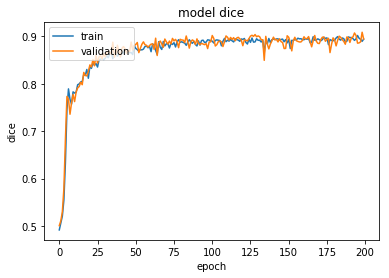

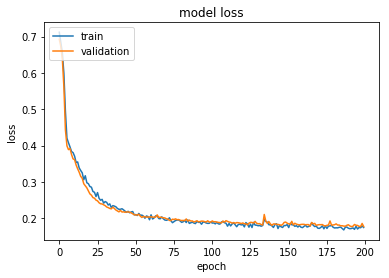

In [12]:
show_plots(hist_epi)

In [53]:
model_epi.load_weights('saved_models/epi_models/weightsNoDrop.hdf5')

print("Epicardium Model Results")
print("========================")
print("Training Statistics(No Dropout)...")
calculate_dice(train_images,train_outer_masks)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images,validation_outer_masks)

Epicardium Model Results
Training Statistics(No Dropout)...
Dice Average: 0.90 Dice Stdev: 0.03
Validation Statistics(No Dropout)...
Dice Average: 0.91 Dice Stdev: 0.03


# View Predictions on training

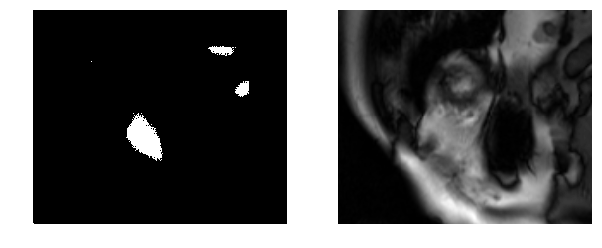

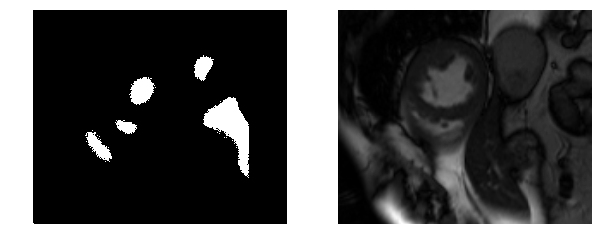

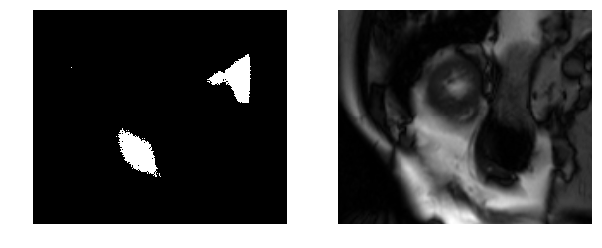

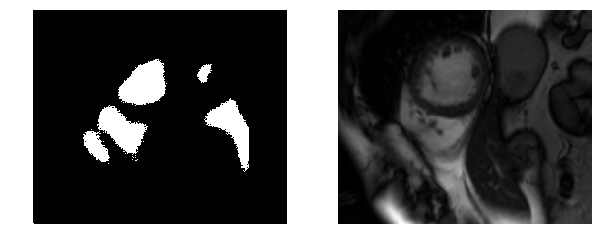

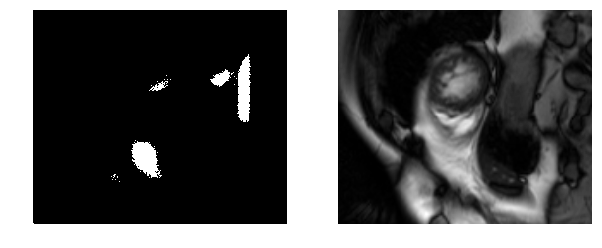

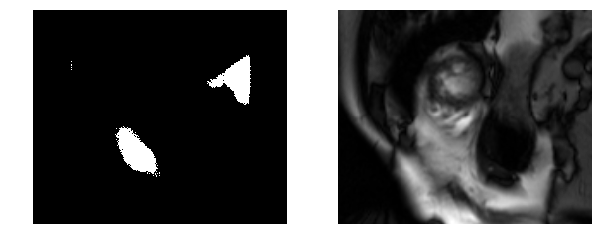

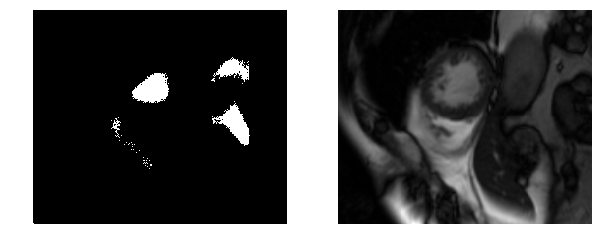

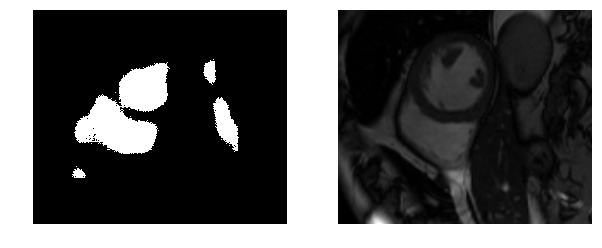

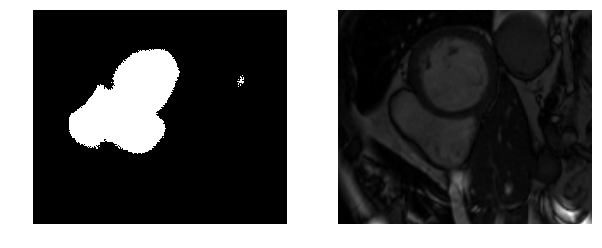

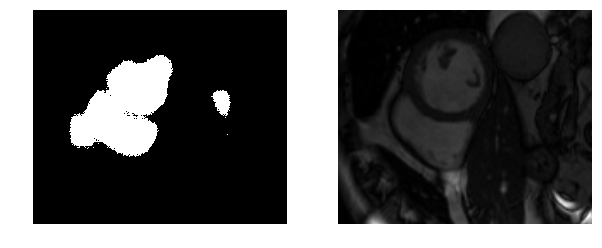

In [23]:
model.load_weights('saved_models/endo_models/weightsNoDrop.hdf5')

def show_masks(images):
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    for (image,mask) in zip(images,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1)
        plt.axis("off")
        #print(mask.shape)
        #print(image.shape)
        plt.imshow(np.where(mask[:,:,1]>0.25,255,0).astype('uint8'), 'gray',interpolation='none')
        plt.subplot(1, 2, 2)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        
show_masks(train_images[:10])